# SageMaker Model Training and Prediction
## Introduction
[Amazon SageMaker](https://aws.amazon.com/sagemaker/?sc_channel=PS&sc_campaign=pac_ps_q4&sc_publisher=google&sc_medium=sagemaker_b_pac_search&sc_content=sagemaker_e&sc_detail=aws%20sagemaker&sc_category=sagemaker&sc_segment=webp&sc_matchtype=e&sc_country=US&sc_geo=namer&sc_outcome=pac&s_kwcid=AL!4422!3!245225393502!e!!g!!aws%20sagemaker&ef_id=WL2I0wAAAIRC8xLB:20180418161912:s) is a fully mamnaged platform that enables Data Scientists to build, train and deploy machine learning models at any scale. It provides key services necessary to create and manage a Machine Learning (ML) Pipeline from "Notebook" to "Production", as highlighted below:

<img src="images/SageMaker_Workflow.png" style="width:800px;height:200px;">

The following Notebook demonstrates this process by using the same Multi-Layer Perceptron (MLP) example from [Demo 1](https://github.com/darkreapyre/itsacat/blob/Demo-1/README.md), with SageMaker.

---
## 1 - Using the Notebook instance to understand and Manage the Input Data.
The SageMaker Notebook instace is a fully mananged compute instance that runs the Jupyter Notebook application and allows the *Data Scientist* to explore and preprocess the dataset that is used to train the ML model. The Notebook instance can also be thought of as an Integrated Development Environment (IDE) for writting the code for the ML model, training the model as wella as testing/validating the model's performance. For more information on using the SageMaker Notebook Instances, see the [SageMaker Developer Guide](https://docs.aws.amazon.com/sagemaker/latest/dg/nbi.html).

### Permissions and Environmental Variables

The packages that will be needed to prepare the data and train the model are as follows:
- [datetime](https://docs.python.org/2/library/datetime.html) provides classes for manipulating dates and times in both simple and complex ways.
- [numpy](https://www.numpy.org) is the fundamental package for scientific computing with Python.
- [matplotlib](https://matplotlib.org) is a famous library to plot graphs in Python.
- [PIL](http://www.pythonware.com/products/pil/) is used here to test the model on unseen image data at the end.
- [boto3](https://pypi.python.org/pypi/boto3) is the Amazon Web Services (AWS) Software Development Kit (SDK) for Python, which allows Python developers to write software that makes use of services like Amazon S3 and Amazon EC2.
- [json](https://docs.python.org/3/library/json.html) is a lightweight data interchange format inspired by JavaScript object literal syntax (although it is not a strict subset of JavaScript.
- [os](https://docs.python.org/3/library/os.html) is a module the provides a portable way of using operating system dependent functionality. Particularly the  environ object is a mapping object representing the environment.
- [tarfile](https://docs.python.org/3/library/tarfile.html) is used to read and write tar archives, when extracting the model training results from S3.
- [mxnet](http://mxnet.incubator.apache.org) is a flexable and effecient library for deep learning.
- [SageMaker Python SDK](https://github.com/aws/sagemaker-python-sdk) is an open source library for training and deploying machine learning models on Amazon SageMaker.

In [1]:
# Import libraries
import warnings; warnings.simplefilter('ignore')
import os
import boto3
import sagemaker
import h5py
import json
import tarfile
import datetime
import matplotlib.pyplot as plt
import numpy as np
import mxnet as mx
from sagemaker.mxnet import MXNet
from mxnet import gluon
%matplotlib inline

# Configure SageMaker
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

### Input Data Preparation
To train the Neural Network, we are provided with a dataset (`datasets.h5`) containing:
- a training set of $m$ images containing cats and non-cats as well as the appropriate class labels ($y=1$) and non-cat images ($y=0$).
- a test set of $m$ images containing cats and non-cat as well as the appropriate class labels ($y=1$) and non-cat images ($y=0$).

>**Note:** The original dataset was comprised of two separate files, `test_catvnoncat.h5` and `train_catvnoncat.h5`. For the sake of this implementation a single file is used, `datasets.h5`.

In [2]:
# Create local repository for Numpy Arrays
if not os.path.exists('/tmp/data'):
    os.mkdir('/tmp/data')

# Load the Training and Testing dataset
dataset = h5py.File('datasets/datasets.h5', 'r')

# Save the Dataset as Numpy Arrays
np.save('/tmp/data/train_X.npy', np.array(dataset['train_set_x'][:]))
np.save('/tmp/data/train_Y.npy', np.array(dataset['train_set_y'][:]))
np.save('/tmp/data/test_X.npy', np.array(dataset['test_set_x'][:]))
np.save('/tmp/data/test_Y.npy', np.array(dataset['test_set_y'][:]))

From the cell above, the image training and testing (validation) input data (`train_set_x` and `test_set_x`) are 4-dimensional arrays consiting of $209$ training examoples ($m$) and $50$ testing images. Each image is in turn of height, width and depth (**R**ed, **G**reen **B**lue values) of $64 \times 64 \times 3$. Additionally, the dimension for the "true" labels (`train_set_y` and `test_set_y`) only show a $209$ and $50$ column structure.  

In [3]:
# Training data set dimensions
print("Training Data Dimension: {}".format(np.load('/tmp/data/train_X.npy').shape))
print("No. Training Examples: {}".format(np.load('/tmp/data/train_X.npy').reshape((-1, 12288)).shape[0]))
print("No. Training Features: {}".format(np.load('/tmp/data/train_X.npy').reshape((-1, 12288)).shape[1]))

Training Data Dimension: (209, 64, 64, 3)
No. Training Examples: 209
No. Training Features: 12288


In [4]:
# Testing data set dimensions
print("Testing Data Dimension: {}".format(np.load('/tmp/data/test_X.npy').shape))
print("No. Testing Examples: {}".format(np.load('/tmp/data/test_X.npy').reshape((-1, 12288)).shape[0]))
print("No. Testing Features: {}".format(np.load('/tmp/data/test_X.npy').reshape((-1, 12288)).shape[1]))

Testing Data Dimension: (50, 64, 64, 3)
No. Testing Examples: 50
No. Testing Features: 12288


The following code cell shows the *observation label* and its corresponding *image*.

y = 1, and therefore it's a "cat" picture.


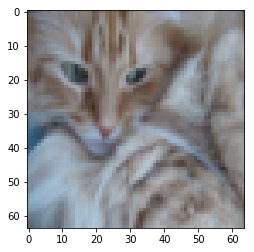

In [5]:
# Example of a cat picture
plt.imshow(np.load('/tmp/data/train_X.npy')[2]);
print("y = {}, and therefore it's a \"cat\" picture.".format(np.load('/tmp/data/train_Y.npy')[2]))

### Input Data Upload
In order for *SageMaker* to execute the training and validation process on the Input Data, the data needs to be uploaded to S3. *SageMaker* provides the handy function, `upload_data()`, to upload the Numpy data to a default (or specific) location. If not already created, the function will create an S3 bucket. The resulting S3 bucket will also store the various training and testing output that will be used for creating production *Endpoints* and *Analysis*.

In [6]:
# Upload the Training and Testing Data to S3
input_data = sagemaker_session.upload_data(path='/tmp/data', key_prefix='training_input')
bucket = input_data.split('/')[2]

## 2 - Training the Classifier as a SageMaker Training Job.
### Training Function
The *Training Function*, `model.py`, contains the instructions that *SageMaker* needs to:
1. Load the Input training and validation data sets from S3; `get_data()`.
2. Pre-process, "vectorize" and scale the image data to be processed by the Neural Network; `transform()`.
3. Train the model and validate the prediction accuracy of the proposed Neural Network model on the Input data; `train()`.
4. Save the model and training results to S3; `save()`.

Below is a graphical representation of the Neural Network model implemented in the *Training Function*.

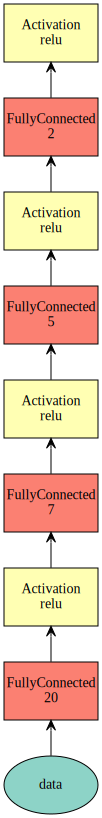

In [7]:
from model import create_graph
net = create_graph()
net.collect_params().initialize()
x = mx.sym.var('data')
sym = net(x)
mx.viz.plot_network(sym)

For an overview of the model function code, refer to [Appendix A](#Appendix-A:-Image-Classification-Model).

### MXNet Estimator
*SageMaker* provides built-in functionality to train and host [MXNet](http://mxnet.incubator.apache.org) and [Gluon](http://gluon.mxnet.io) models, using the `MXNet` class of the [SageMaker Python SDK](https://github.com/aws/sagemaker-python-sdk). Leveraging the MXNet Estimator drastically simplifies the handling of end-to-end training as well as deployment of custom MXNet models.

Using the code (below), the model itself, the location of the training data and the Hyperparameters are applied to the MXNet Estimator.

In [8]:
# Create a MXNet Estimator
mxnet_estimator = MXNet(
    'model.py',
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.xlarge',
    output_path='s3://'+bucket,
    hyperparameters={
        'epochs': 2500,
        'optmizer': 'sgd',
        'learning_rate': 0.0075,
        'batch_size': 64,
        'threshold': 0.0019
    }
)

### Training Job
By calling the estimator's `fit()` method, with the location of the training data, SageMaker can start the model training using the configuration provided. After the training is successfully completed, the training results can be analyzed. Should the results prove that the model is optimal, It can then be deployed to *SageMaker's* hosting services.
>**Note:** Make sure to note the Training Job Name as it will be used in the next step.

In [9]:
##############################################################################################
#                   Create a custom job name for current training run                        #
#job_name = '<<Specific Training Job Name>>'                                                 #
#mxnet_estimator.fit(input_data, job_name=job_name) # Fit the estimator to custom job name   #
##############################################################################################

# Automatically generate training job name
mxnet_estimator.fit(input_data)

INFO:sagemaker:Creating training-job with name: sagemaker-mxnet-2018-05-23-01-53-00-771


.................
2018-05-23 01:55:32,309 INFO - root - running container entrypoint
2018-05-23 01:55:32,309 INFO - root - starting train task
2018-05-23 01:55:32,314 INFO - container_support.training - Training starting
2018-05-23 01:55:34,456 INFO - mxnet_container.train - MXNetTrainingEnvironment: {'enable_cloudwatch_metrics': False, 'available_gpus': 0, 'channels': {u'training': {u'TrainingInputMode': u'File', u'RecordWrapperType': u'None', u'S3DistributionType': u'FullyReplicated'}}, '_ps_verbose': 0, 'resource_config': {u'current_host': u'algo-1', u'hosts': [u'algo-1']}, 'user_script_name': u'model.py', 'input_config_dir': '/opt/ml/input/config', 'channel_dirs': {u'training': u'/opt/ml/input/data/training'}, 'code_dir': '/opt/ml/code', 'output_data_dir': '/opt/ml/output/data/', 'output_dir': '/opt/ml/output', 'model_dir': '/opt/ml/model', 'hyperparameters': {u'sagemaker_program': u'model.py', u'learning_rate': 0.0075, u'batch_size': 64, u'epochs': 2500, u'sagemaker_enable_cloudwa

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sagemaker/session.py:630: DeprecationWarning: generator 'multi_stream_iter' raised StopIteration
  for idx, event in sagemaker.logs.multi_stream_iter(client, log_group, stream_names, positions):


===== Job Complete =====
Billable seconds: 130


---
## 3 - Performance Analysis of the Trained Model.
After a model has been trained and before it can be leveraged in production, it must be tested. This testing process typically takes the form of:
1. **Analyzing the results from the training process:**
    A good indication that the model performs well on the training data is to verify that the overall Training Error (Cost Function) decreases after every iteration of the forward propagation process.
2. **Classification Accuracy (Training data set):**
    While the Training Error provides a good indication of how well the Neural Network out probabilities agree with the observed labels, a common evaluation metric used for classification models sn the **Accuracy Score**. This metric generally summarizes the number of correct predictions the classifier has made as a ratio of all the predictions.
3. **Classification Accuracy (Test/Validation data set):**
    A good practice in machine learning is to create a subset of the training data keep it separate for testing. This is typically referred to as a hold-out, validation or test set. By testing how well the model performance against this data, further insight can be derived.
    
As can be seen from the output from training process above, the model learn the features of the training set to accurately classify the observed label. Additionally, when the model applies the optimized parameters to classify the test data, it achieves as overall accuracy of $80%$.

Since the training function also captures these results to S3, the Cost/Error, training set Accuracy and test set Accuracy can be visualized as follows:
>**Note**: Be sure to enter the name of the above SageMaker training job in `job_name` variable.

Model Training Time: 1 Minute(s)


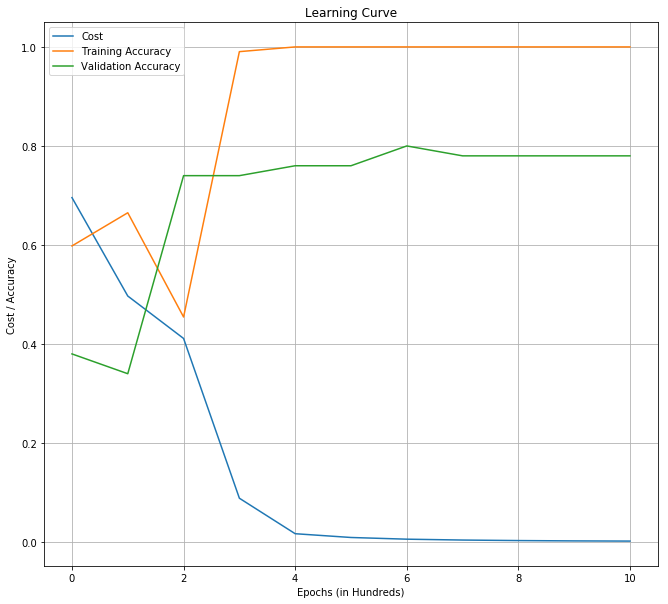

In [10]:
# Download and uncompress output results from model training
job_name = 'sagemaker-mxnet-2018-05-23-01-53-00-771'
s3 = boto3.resource('s3')
s3.Bucket(bucket).download_file(job_name+'/output/output.tar.gz', '/tmp/output.tar.gz')
tarfile.open('/tmp/output.tar.gz').extractall()
with open('results.json') as j:
    data = json.load(j)#, object_pairs_hook=OrderedDict)

# Format data for plotting
costs = []
val_acc = []
train_acc = []
for key, value in sorted(data.items()):#, key=lambda (k,v): (v, k)):
    if 'epoch' in key:
        for k, v in value.items():
            if k == 'cost':
                costs.append(v)
            elif k == 'val_acc':
                val_acc.append(v)
            elif k == 'train_acc':
                train_acc.append(v)
    elif 'Start' in key:
        start = datetime.datetime.strptime(value, "%Y-%m-%d %H:%M:%S.%f")
    elif 'End' in key:
        end = datetime.datetime.strptime(value, "%Y-%m-%d %H:%M:%S.%f")
val_acc = np.array(val_acc)
train_acc = np.array(train_acc)
costs = np.array(costs)
delta = end - start
print("Model Training Time: {} Minute(s)".format(int(delta.total_seconds() / 60)))

# Plot the Learning Curve
plt.rcParams['figure.figsize'] = (11.0, 10.0)
plt.grid(True, which='both')
plt.plot(costs)
plt.plot(train_acc)
plt.plot(val_acc)
plt.ylabel('Cost / Accuracy')
plt.xlabel('Epochs (in Hundreds)')
plt.title("Learning Curve")
plt.legend(['Cost', 'Training Accuracy', 'Validation Accuracy'])
plt.show;

---
## 4 - Performance Analysis of the Inference Endpoint.
Testing the model against an image that is neither part of the training data or the testing data will provide realistic proof of it's performance in production. The following code cells demonstrate how the trained model performs against a selection of images that have pictures of cats as well as "other" pictures.

To further simulate the predictive capabilities of the trained mode in a production environment, the `deploy()` method of the estimator is called to host the model on the *SageMaker* [hosting services](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-hosting.html) which provides an HTTPS endpoint to provide classification inferences on images.

In [11]:
predictor = mxnet_estimator.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: sagemaker-mxnet-2018-05-23-01-53-00-771
INFO:sagemaker:Creating endpoint with name sagemaker-mxnet-2018-05-23-01-53-00-771


---------------------------------------------------------------!

The code cells below show the pseudo production classification inferences on unseen image data by leveraging the hosted predictor.

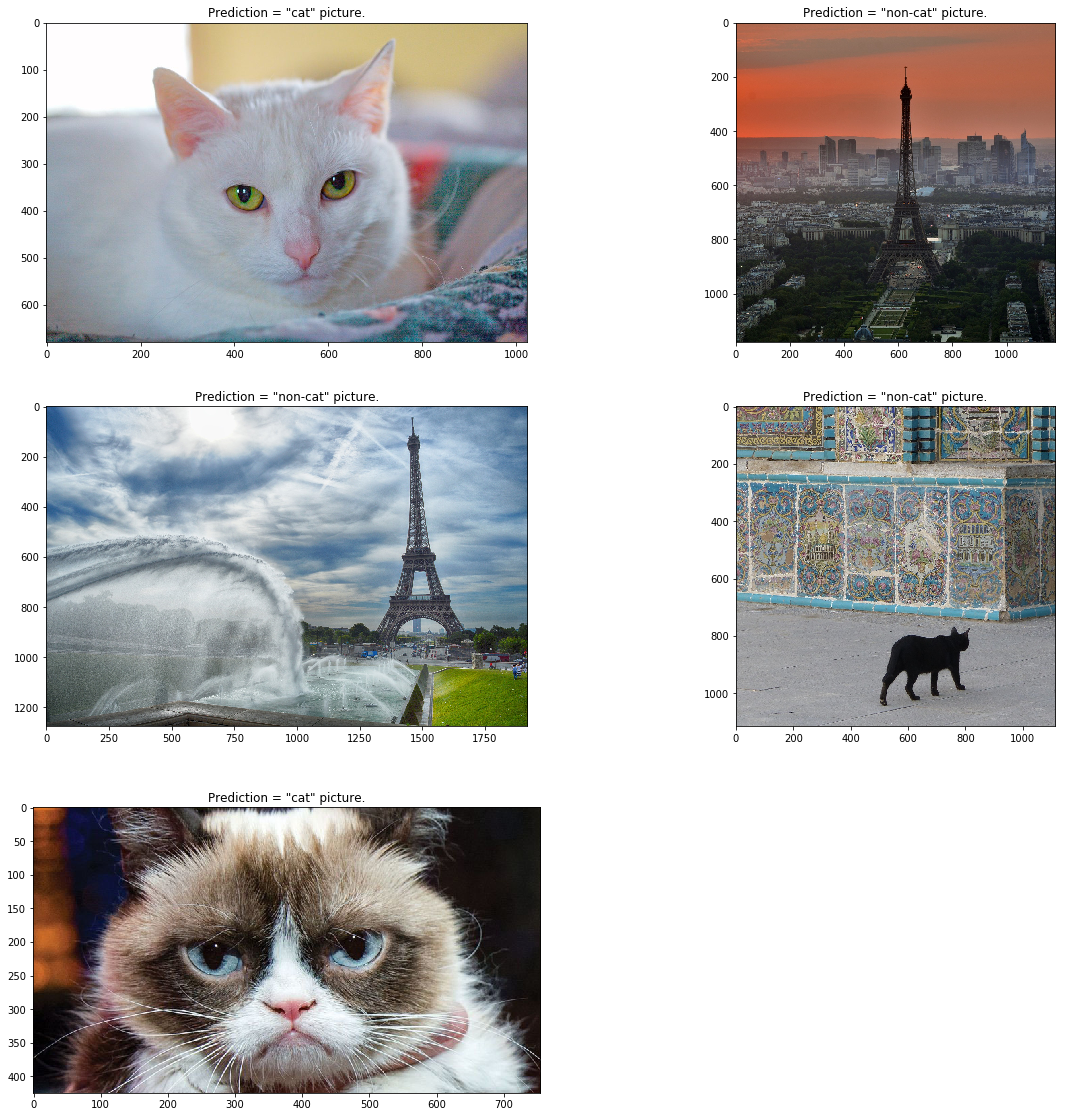

In [12]:
import glob
import matplotlib.image as mpimg
from skimage import transform

# Get Classes
classes = ["non-cat", "cat"]

# Get Image files
images = []
for img_path in glob.glob('./images/*.jpeg'):
    images.append(mpimg.imread(img_path))

# Plot predictions
plt.figure(figsize=(20.0,20.0))
columns = 2
for i, image in enumerate(images):
    img = transform.resize(image, (64, 64), mode='constant').reshape((1, 64 * 64 * 3))
    prediction = int(predictor.predict(img.tolist()))
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.title('Prediction = "{}" picture.'.format(classes[prediction]))
    plt.imshow(image);

__Immitate Flask App__

In [13]:
import urllib3
from PIL import Image
from io import BytesIO
url = 'http://i0.kym-cdn.com/entries/icons/facebook/000/011/365/GRUMPYCAT.jpg'
endpoint_name = 'sagemaker-mxnet-2018-05-23-01-53-00-771'
http = urllib3.PoolManager()
req = http.request('GET', url)
image = np.array(Image.open(BytesIO(req.data)))
result = transform.resize(image, (64, 64), mode='constant').reshape((1, 64 * 64 * 3))
payload = result.tolist()

In [14]:
runtime_client = boto3.client('sagemaker-runtime')
response = runtime_client.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType='application/json',
    Body=json.dumps(payload)
)
prediction = classes[int(json.loads(response['Body'].read().decode('utf-8')))]

print("prediction: {}".format(prediction))

prediction: cat


---

In [15]:
#build_id = 'd5e2332728468d92622aa3578f490e3183f8058f'[:7]
build_id = 'd5e2332'
sagemaker_client = boto3.client('sagemaker')
list_results = sagemaker_client.list_endpoints(
    SortBy='Name',
    NameContains=build_id,
#    MaxResults=1,
    StatusEquals='InService'
)
if not list_results['Endpoints']:
    endpoint_name = 0
else:
    endpoint_name = str(list_results.get('Endpoints')[0]['EndpointName'])
print("Endpoint Name: {}".format(endpoint_name))

Endpoint Name: d5e2332


In [16]:
url = 'http://i0.kym-cdn.com/entries/icons/facebook/000/011/365/GRUMPYCAT.jpg'
http = urllib3.PoolManager()
req = http.request('GET', url)
image = np.array(Image.open(BytesIO(req.data)))
result = transform.resize(image, (64, 64), mode='constant').reshape((1, 64 * 64 * 3))
payload = result.tolist()
runtime_client = boto3.client('sagemaker-runtime')
response = runtime_client.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType='application/json',
    Body=json.dumps(payload)
)
prediction = classes[int(json.loads(response['Body'].read().decode('utf-8')))]

print("prediction: {}".format(prediction))

prediction: cat


---
# Next: Test the Production API
Now that the model has been trained and validated for production, the **Data Science** part of the ML Pipeline can be integrated into the **DevOps** process. Refer back to the [README](../README.md) on the next steps.
>**Note:** Make sure to remember the name of the training job, as it is necessary to complete the next steps.

---
# Appendix A: Image Classification Model

In [ ]:
!cat model.py